# Setup

In [1]:
import ast
import warnings
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

from src.helpers import *

warnings.simplefilter(action='ignore')
pd.options.mode.chained_assignment = None  

First, let's upload the relevant datasets which were generated from [Milestone P2](milestoneP2).

In [4]:
# Load datasets
tmdb_extra_info = pd.read_csv('./generated/TMDB_extra_info.csv')
movie_char = pd.read_csv('./generated/movie_characters.csv')
movie_char_eth = pd.read_csv('./generated/movie_characters_ethnicity.csv')

In [5]:
movie_char['movie_genres'] = movie_char['movie_genres'].apply(lambda s: ast.literal_eval(str(s)))
movie_char['movie_genres'] = movie_char['movie_genres'].apply(lambda d: list(d.values()))

movie_char_eth['movie_genres'] = movie_char_eth['movie_genres'].apply(lambda s: ast.literal_eval(str(s)))
movie_char_eth['movie_genres'] = movie_char_eth['movie_genres'].apply(lambda d: list(d.values()))

# Preprocessing

### Simpson Diversity Index

The key variables in our project are "diversity" and "performance" of the cast. We have chosen to measure these as follows:

- Casting diversity: Ethnicity and Gender of actors
- Film performance: Box office earnings and Ratings

We need a quantitative tool to measure the diversity of a population. For this purpose, we've selected the **Simpson Diversity Index**, defined as follows:

$D = 1 - \sum_{k=1}^{K} \left(\frac{n_k}{N}\right)^2$

Here, **N** represents the total number of units in the population, and **K** denotes the different types within it. For each type **k**, **$n_k$** is the number of units. The value of **D** varies between 0 and 1, with a lower value indicating less diversity in the population.

The index is calculated by assessing the likelihood that two randomly chosen individuals from a sample will not belong to the same species. A key strength of this index is that it considers not just the variety of species present but also the relative abundance of each species. 

However, in cases like gender with only two types, the Simpson Diversity Index will never reach 1. This is because in a two-type system, the index reaches its maximum value of 0.5 when the representation of both types is exactly equal. We can apply a scaling factor to adjust the values to fill the entire $[0, 1]$ range. However, this won't affect the overall analysis as the distribution remains the same.

Regarding the ethnicity diversity, we can consider the following scenarios:

- **Movie 1**: 20% representation for each of 5 ethnicities.
- **Movie 2**: 99% representation of one ethnicity, with 100 different ethnicities comprising the remaining 1%.

We find that **$D_1 = 0.8$** is significantly greater than **$D_2 = 0.02$**. This result is coherent as Movie 1 appears to have a more diverse cast, even though Movie 2 includes a greater number of ethnicities.

Now, let's define the functions that calculate gender and ethnicity diversity for a given set of movies. These functions will operate on a dataframe, where each movie is associated with its characters. 

In [6]:
def calculate_diversity(df, column_name, new_column_name):
    """
    Calculate the diversity index based on the specified column in the dataframe.

    Args:
    df (DataFrame): DataFrame containing movie and actor information.
    column_name (str): Name of the column to calculate diversity for.
    new_column_name (str): Name for the new column to store the diversity index.

    Returns:
    DataFrame: The original DataFrame augmented with the diversity index and actor count.
    """
    # Filter out rows where the specified column is NaN
    filtered_data = df.dropna(subset=[column_name])

    # Group by movie_freebase_id and count each category in the specified column
    counts = filtered_data.groupby('movie_freebase_id')[column_name].value_counts().unstack(fill_value=0)

    # Calculate the total number of actors for each movie
    total_actors = filtered_data.groupby('movie_freebase_id')[column_name].count()

    # Calculate the Simpson Diversity Index
    total_counts = counts.sum(axis=1)
    squared_proportions = (counts.divide(total_counts, axis=0) ** 2).sum(axis=1)
    diversity_index = 1 - squared_proportions

    # Create a DataFrame for the calculated values
    diversity_data = pd.DataFrame({
        new_column_name: diversity_index,
        'actors_count': total_actors
    })

    # Merge the calculated values back with the original DataFrame
    result = df.merge(diversity_data, on='movie_freebase_id', how='inner')

    return result

### Gender diversity preprocessing

In [7]:
movie_char.head()

,movie_wikipedia_id,movie_freebase_id,movie_name,movie_release_year,movie_languages_count,movie_box_office_revenue,character_freebase_id,actor_freebase_id,character_actor_freebase_map_id,character_name,actor_name,actor_gender,actor_age_at_movie_release,movie_genres
0,975900,/m/03vyhn,Ghosts of Mars,2001.0,22,14010832.0,/m/0bgcj3x,/m/03wcfv7,/m/0bgchxw,Akooshay,Wanda De Jesus,F,42.0,"[Thriller, Science Fiction, Horror, Adventure,..."
1,975900,/m/03vyhn,Ghosts of Mars,2001.0,22,14010832.0,/m/0bgchn4,/m/0346l4,/m/0jys3m,Lieutenant Melanie Ballard,Natasha Henstridge,F,27.0,"[Thriller, Science Fiction, Horror, Adventure,..."
2,975900,/m/03vyhn,Ghosts of Mars,2001.0,22,14010832.0,/m/0bgchn_,/m/01vw26l,/m/0jys3g,Desolation Williams,Ice Cube,M,32.0,"[Thriller, Science Fiction, Horror, Adventure,..."
3,975900,/m/03vyhn,Ghosts of Mars,2001.0,22,14010832.0,/m/0bgchnq,/m/034hyc,/m/02vchl6,Sgt Jericho Butler,Jason Statham,M,33.0,"[Thriller, Science Fiction, Horror, Adventure,..."
4,975900,/m/03vyhn,Ghosts of Mars,2001.0,22,14010832.0,/m/0bgchp9,/m/01y9xg,/m/02vbb3r,Bashira Kincaid,Clea DuVall,F,23.0,"[Thriller, Science Fiction, Horror, Adventure,..."


In [8]:
# Calculate gender diversity and remove duplicates based on movie ID
gender_diversities_df = calculate_diversity(movie_char, 'actor_gender', 'gender_diversity').drop_duplicates(subset='movie_freebase_id')

# Filter out movies with missing actors or genders and print the resulting dataframe shape
gender_diversities_df = gender_diversities_df[gender_diversities_df['actors_count'] > 1]
print(f"Shape of new the dataframe: {gender_diversities_df.shape}")

Shape of new the dataframe: (54148, 16)


In [9]:
# Merge with additional ratings info and select relevant columns
relevant_columns = ['movie_freebase_id', 'movie_name', 'movie_release_year', 
                    'movie_languages_count', 'movie_genres', 'gender_diversity', 
                    'actors_count', 'rating_average', 'rating_count', 
                    'movie_box_office_revenue']

gender_merged_df = gender_diversities_df.merge(tmdb_extra_info, on='movie_freebase_id', how='inner')[relevant_columns]

print(f"Shape of the new dataframe: {gender_merged_df.shape}")

KeyError: 'movie_freebase_id'

Now, it's necessary to remove outliers in box office earnings for the following reasons :

- Major blockbusters, which generate significantly higher revenue than other movies, may not adhere to standard cinematic norms and could skew the analysis.
- Films with exceptionally high earnings should also be excluded to prevent bias in the analysis.
- To ensure the data is normalized effectively.

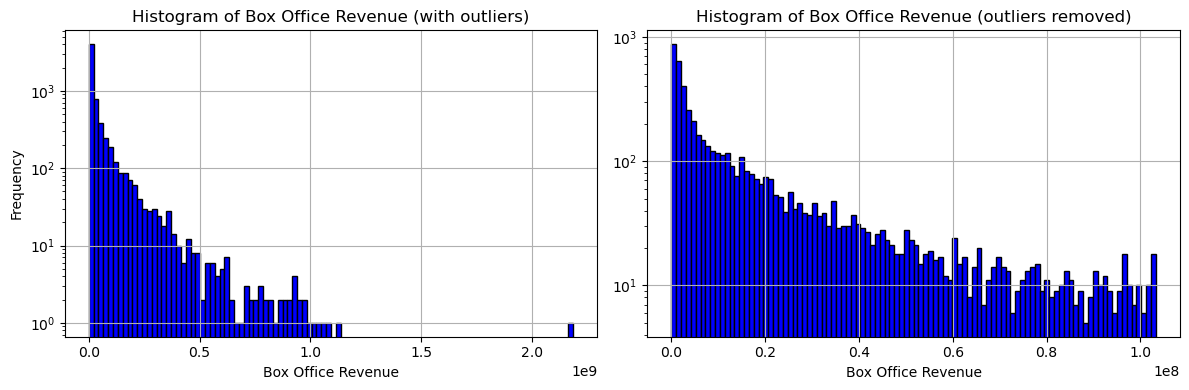

Shape of the old dataframe with box office outliers: (30672, 10)
Shape of the new dataframe without box office outliers: (29887, 10)


In [ ]:
gender_merged_without_outliers_df = remove_outliers(gender_merged_df, "movie_box_office_revenue")

# Plotting the histograms in one figure
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].hist(gender_merged_df['movie_box_office_revenue'], bins=100, color='blue', edgecolor='black', log=True)
axs[0].set_title('Histogram of Box Office Revenue (with outliers)')
axs[0].set_xlabel('Box Office Revenue')
axs[0].set_ylabel('Frequency')
axs[0].grid(True)

axs[1].hist(gender_merged_without_outliers_df['movie_box_office_revenue'], bins=100, color='blue', edgecolor='black', log=True)
axs[1].set_title('Histogram of Box Office Revenue (outliers removed)')
axs[1].set_xlabel('Box Office Revenue')
axs[1].grid(True)

plt.tight_layout()
plt.show()

print(f"Shape of the old dataframe with box office outliers: {gender_merged_df.shape}")
print(f"Shape of the new dataframe without box office outliers: {gender_merged_without_outliers_df.shape}")

Now let's compare the distributions resulting from several normalization methods: Min-Max scaling and Z-score normalization.

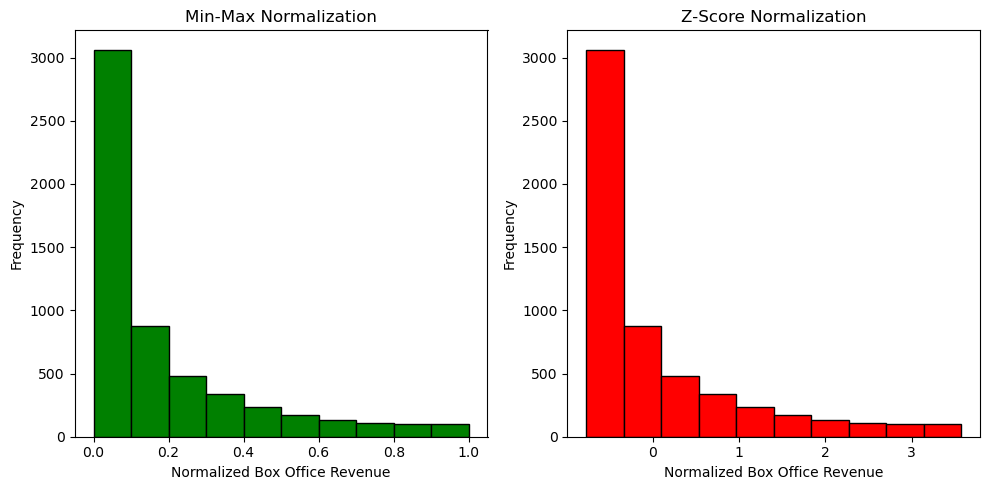

In [ ]:
# Normalizing using Min-Max Scaling
normalized_minmax = (gender_merged_without_outliers_df['movie_box_office_revenue'] - gender_merged_without_outliers_df['movie_box_office_revenue'].min()) / (gender_merged_without_outliers_df['movie_box_office_revenue'].max() - gender_merged_without_outliers_df['movie_box_office_revenue'].min())

# Normalizing using Z-Score Normalization
normalized_zscore = (gender_merged_without_outliers_df['movie_box_office_revenue'] - gender_merged_without_outliers_df['movie_box_office_revenue'].mean()) / gender_merged_without_outliers_df['movie_box_office_revenue'].std()

# Plotting histograms for both normalization techniques
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.hist(normalized_minmax, bins=10, color='green', edgecolor='black')
plt.title('Min-Max Normalization')
plt.xlabel('Normalized Box Office Revenue')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(normalized_zscore, bins=10, color='red', edgecolor='black')
plt.title('Z-Score Normalization')
plt.xlabel('Normalized Box Office Revenue')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

The distributions appear quite similar. Let's opt for the Z-score normalization, as it is more commonly used.

In [ ]:
# Normalize the columns using Z-score normalization
gender_normalized_df = normalize_columns_zscore(gender_merged_without_outliers_df.copy(), ["movie_box_office_revenue"])

gender_normalized_df.head()

,movie_freebase_id,movie_name,movie_release_year,movie_languages_count,movie_genres,gender_diversity,actors_count,rating_average,rating_count,movie_box_office_revenue
0,/m/03vyhn,Ghosts of Mars,2001.0,22,"[Thriller, Science Fiction, Horror, Adventure,...",0.456747,17,5.127,990,-0.186806
1,/m/0crgdbh,Brun bitter,1988.0,23,"[Crime Fiction, Drama]",0.500000,4,0.000,0,NaN
2,/m/0285_cd,White Of The Eye,1987.0,22,"[Thriller, Erotic thriller, Psychological thri...",0.500000,2,5.700,64,NaN
3,/m/01mrr1,A Woman in Flames,1983.0,20,[Drama],0.444444,3,5.300,13,NaN
4,/m/04jcqvw,The Sorcerer's Apprentice,2002.0,22,"[Family Film, Fantasy, Adventure, World cinema]",0.320000,5,4.600,11,NaN


Finally, let's create a histogram to visualize the distribution of the gender diversity.

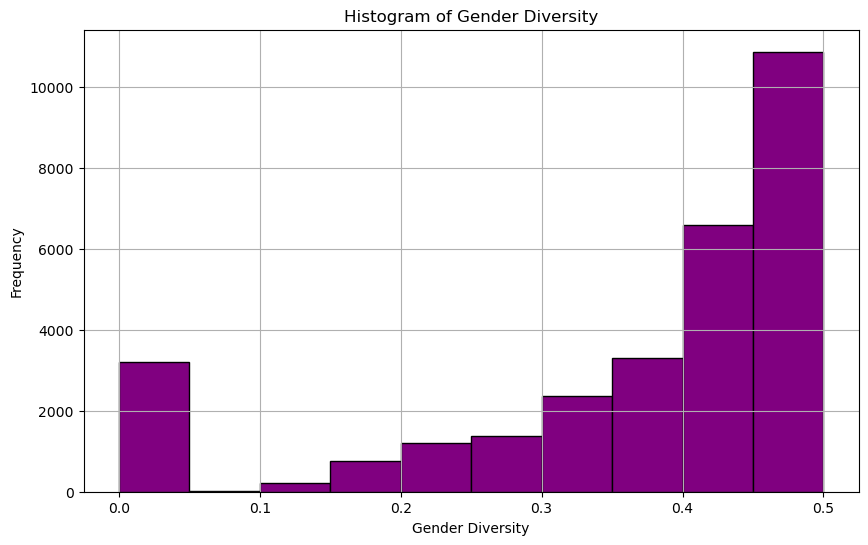

In [ ]:
# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(gender_normalized_df['gender_diversity'], bins=10, color='purple', edgecolor='black')
plt.title('Histogram of Gender Diversity')
plt.xlabel('Gender Diversity')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

The distribution appears appropriate: 
- Many movies feature only male actors, which accounts for the noticeable instances of a 0 diversity score.
- The distribution is not symmetrical. While there are numerous movies with a predominance of male actors, the same is not true for female actors.

### Ethnicity diversity preprocessing

In [ ]:
movie_char_eth.head()

,movie_wikipedia_id,movie_freebase_id,movie_name,movie_release_year,movie_languages_count,movie_box_office_revenue,character_freebase_id,actor_freebase_id,character_actor_freebase_map_id,character_name,actor_name,actor_gender,actor_age_at_movie_release,movie_genres,actor_ethnicity
0,975900,/m/03vyhn,Ghosts of Mars,2001.0,22,14010832.0,/m/0bgchn_,/m/01vw26l,/m/0jys3g,Desolation Williams,Ice Cube,M,32.0,"[Thriller, Science Fiction, Horror, Adventure,...",African Americans
1,975900,/m/03vyhn,Ghosts of Mars,2001.0,22,14010832.0,/m/0bgchnd,/m/0418ft,/m/02vdcfp,Commander Helena Braddock,Pam Grier,F,52.0,"[Thriller, Science Fiction, Horror, Adventure,...",African Americans
2,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000.0,22,NaN,NaN,/m/01lntp,/m/0lr37dy,NaN,Albert Hall,M,62.0,"[Mystery, Biographical film, Drama, Crime Drama]",African Americans
3,156558,/m/014k4y,Baby Boy,2001.0,22,29381649.0,/m/03jnxj_,/m/0blbxk,/m/0jtx5t,Yvette,Taraji P. Henson,F,30.0,"[Crime Fiction, Drama, Coming of age]",African Americans
4,156558,/m/014k4y,Baby Boy,2001.0,22,29381649.0,/m/03jnxf4,/m/01l1b90,/m/0jtx5h,Jody,Tyrese Gibson,M,22.0,"[Crime Fiction, Drama, Coming of age]",African Americans


In [ ]:
# Calculate gender diversity and remove duplicates based on movie ID
ethnicity_diversities_df = calculate_diversity(movie_char_eth, 'actor_ethnicity', 'ethnicity_diversity').drop_duplicates(subset='movie_freebase_id')

# Filter out movies with missing actors and print the resulting dataframe shape
ethnicity_diversities_df = ethnicity_diversities_df[ethnicity_diversities_df['actors_count'] > 1]
print(f"Shape of new the dataframe: {ethnicity_diversities_df.shape}")

Shape of new the dataframe: (22322, 17)


In [ ]:
# Merge with additional ratings info and select relevant columns
relevant_columns = ['movie_freebase_id', 'movie_name', 'movie_release_year', 
                    'movie_languages_count', 'movie_genres', 'ethnicity_diversity', 
                    'actors_count', 'rating_average', 'rating_count', 
                    'movie_box_office_revenue']

ethnicity_merged_df = ethnicity_diversities_df.merge(tmdb_extra_info, on='movie_freebase_id', how='inner')[relevant_columns]

print(f"Shape of the new dataframe: {ethnicity_merged_df.shape}")

Shape of the new dataframe: (12643, 10)


Again, we need to exclude box office outliers for the same reasons as with the gender diversity.

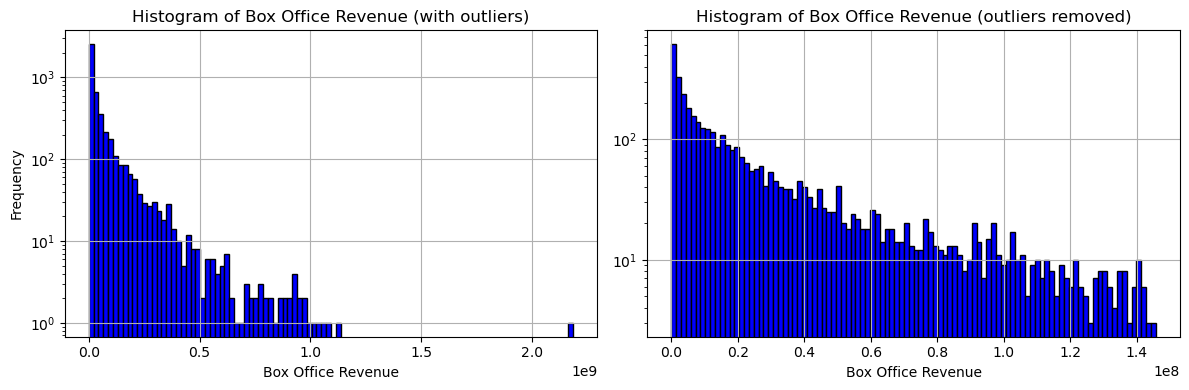

Shape of the old dataframe with box office outliers: (12643, 10)
Shape of the new dataframe without box office outliers: (12088, 10)


In [ ]:
ethnicity_merged_without_outliers_df = remove_outliers(ethnicity_merged_df, "movie_box_office_revenue")

# Plotting the histograms in one figure
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].hist(ethnicity_merged_df['movie_box_office_revenue'], bins=100, color='blue', edgecolor='black', log=True)
axs[0].set_title('Histogram of Box Office Revenue (with outliers)')
axs[0].set_xlabel('Box Office Revenue')
axs[0].set_ylabel('Frequency')
axs[0].grid(True)

axs[1].hist(ethnicity_merged_without_outliers_df['movie_box_office_revenue'], bins=100, color='blue', edgecolor='black', log=True)
axs[1].set_title('Histogram of Box Office Revenue (outliers removed)')
axs[1].set_xlabel('Box Office Revenue')
axs[1].grid(True)

plt.tight_layout()
plt.show()

print(f"Shape of the old dataframe with box office outliers: {ethnicity_merged_df.shape}")
print(f"Shape of the new dataframe without box office outliers: {ethnicity_merged_without_outliers_df.shape}")

In [ ]:
# Normalize the columns using Z-score normalization
ethnicity_normalized_df = normalize_columns_zscore(ethnicity_merged_without_outliers_df.copy(), ["movie_box_office_revenue"])

ethnicity_normalized_df.head()

,movie_freebase_id,movie_name,movie_release_year,movie_languages_count,movie_genres,ethnicity_diversity,actors_count,rating_average,rating_count,movie_box_office_revenue
0,/m/03vyhn,Ghosts of Mars,2001.0,22,"[Thriller, Science Fiction, Horror, Adventure,...",0.444444,3,5.127,990,-0.403776
1,/m/0cws46,Kinjite: Forbidden Subjects,1989.0,22,"[Crime Fiction, Action/Adventure, Action, Thri...",0.666667,3,5.400,69,-0.725625
2,/m/0dyy_v,Vixen!,1968.0,22,"[Softcore Porn, Sexploitation]",0.500000,2,5.300,70,NaN
3,/m/02x4zpv,The Boston Strangler,1968.0,22,"[Crime Fiction, Mystery, Thriller, Drama, Crim...",0.750000,4,6.810,197,-0.288329
4,/m/04j0jtp,Deadly Voyage,1996.0,22,"[Thriller, Action Thrillers, Horror, Televisio...",0.750000,8,5.600,9,NaN


Again, let's create a histogram to visualize the distribution of the ethnicity diversity.

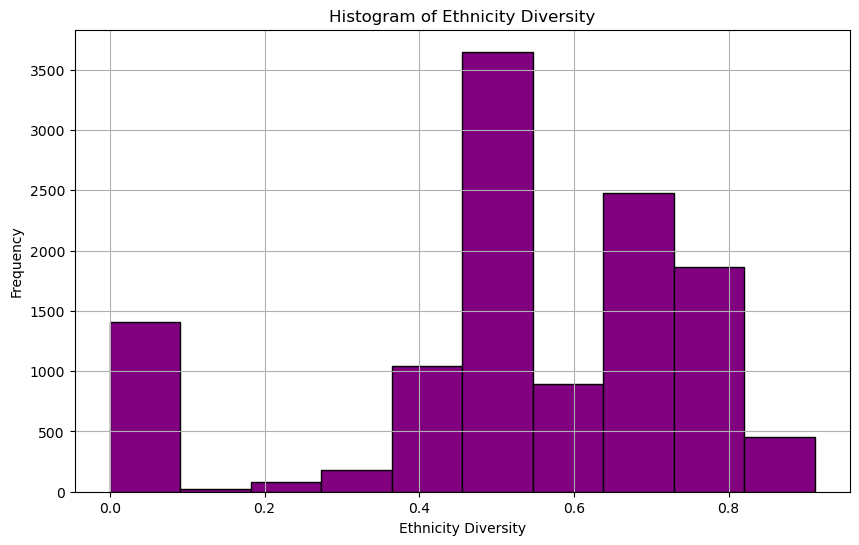

In [ ]:
# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(ethnicity_normalized_df['ethnicity_diversity'], bins=10, color='purple', edgecolor='black')
plt.title('Histogram of Ethnicity Diversity')
plt.xlabel('Ethnicity Diversity')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

The distribution seems suitable:
- A considerable number of local movies feature actors exclusively from the same country or ethnicity, which accounts for the noticeable instances of a 0 diversity score.
- This distribution is derived using the Simpson diversity index, which considers two actors diverse if they do not have the exact same label. Given the dataset's extreme imbalance in terms of ethnicities, it's expected that the distribution won't be smooth. However, it's noteworthy that the frequency appears lower at the extremes and higher around the 0.5 mark.

### Save the dataframes

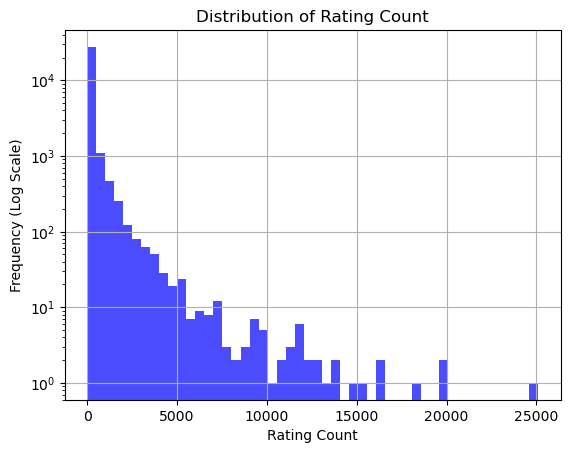

Percentage of non null rating count 'rating_count': 93.01%


In [ ]:
rating_count = gender_normalized_df["rating_count"]

# Plotting the rating count histogram with a logarithmic scale for the y-axis
plt.hist(rating_count, bins=50, color='blue', alpha=0.7, log=True)
plt.title('Distribution of Rating Count')
plt.xlabel('Rating Count')
plt.ylabel('Frequency (Log Scale)')
plt.grid(True)
plt.show()

# Calculating the percentage of non null rating count
total_count = len(gender_normalized_df)
non_null_ratings_count = len(gender_normalized_df[gender_normalized_df["rating_count"] > 0])
non_null_ratings_percentage = (non_null_ratings_count / total_count) * 100

print(f"Percentage of non null rating count 'rating_count': {non_null_ratings_percentage:.2f}%")

We observe that 7% of the movies do not have a rating. However, we will not exclude these from our dataset as they may still possess box office value. Since the ratings and box office figures will be analyzed separately, we will only remove these movies when necessary, in order to avoid data loss. Additionally, we might consider implementing a threshold for the rating count, thereby focusing only on averages of ratings that are deemed relevant.

In [ ]:
# Saving the dataframes as CSV files
gender_normalized_df.to_csv('gender_diversity.csv', index=False)
ethnicity_normalized_df.to_csv('ethnicity_diversity.csv', index=False)

### Ethnicity clustering

We could consider applying clustering to the ethnicities to achieve a more general categorization.

In [ ]:
# Let's calculate the number of different ethnicities
unique_ethnicities_count = movie_char_eth['actor_ethnicity'].nunique()
print(f"The number of different ethnicities in the dataset is: {unique_ethnicities_count}")

# Now let's find the movie with the most actors from different ethnic backgrounds
movie_ethnicity_counts = movie_char_eth.groupby('movie_freebase_id')['actor_ethnicity'].nunique()
movie_with_most_ethnic_diversity = movie_ethnicity_counts.idxmax()

# Now we can print the movie name instead of the movie ID
movie_with_most_ethnic_diversity_name = movie_char_eth[movie_char_eth['movie_freebase_id'] == movie_with_most_ethnic_diversity].iloc[0]['movie_name']

# Printing the movie name with the most diverse ethnic backgrounds among actors
print(f"The movie with the most actors from different ethnic backgrounds is \"{movie_with_most_ethnic_diversity_name}\" with {movie_ethnicity_counts[movie_with_most_ethnic_diversity]} distinct ethnicities")

The number of different ethnicities in the dataset is: 435
The movie with the most actors from different ethnic backgrounds is "Terror in the Aisles" with 15 distinct ethnicities


Let's examine the distribution of ethnicities within the dataset, ensuring that each actor is counted only once.

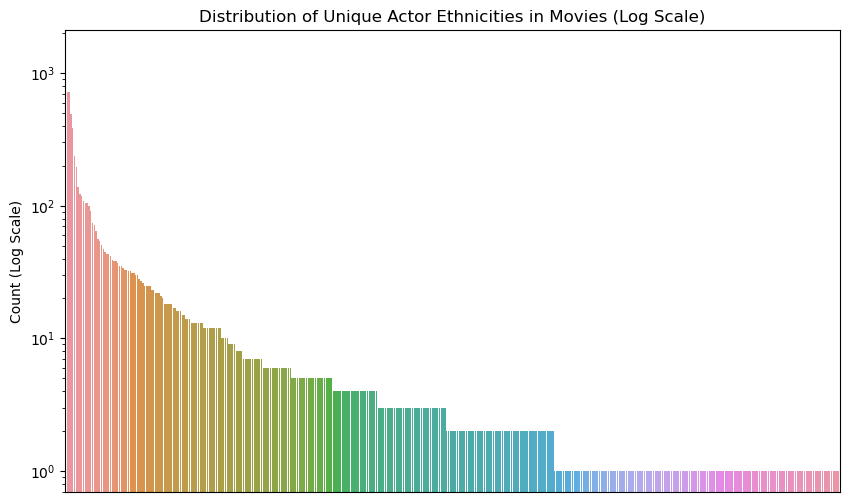

In [ ]:
# We first drop duplicates to ensure each actor is counted only once
unique_actors = movie_char_eth.drop_duplicates(subset=['actor_name'])

# Now, count the unique ethnicities
ethnicity_counts = unique_actors["actor_ethnicity"].value_counts()

# Creating a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=ethnicity_counts.index, y=ethnicity_counts.values)

# Setting the y-axis to logarithmic scale
plt.yscale('log')

# Removing x-axis labels
plt.xlabel('')
plt.xticks([])

plt.ylabel('Count (Log Scale)')
plt.title('Distribution of Unique Actor Ethnicities in Movies (Log Scale)')
plt.show()

Now, let's define clusters with a mapping function.

In [ ]:
ethnic_cluster = {
    "East Asian": [
        "Han Chinese people", "Zhuang people", "Ryukyuan people", "Manchu", "Gin people"
    ],
    "South Asian": [
        "Afghans in India", "Agrawal", "Bengali Brahmins", "Bengali Hindus", "Bengali people", "Bihari people",
        "Gujarati people", "Indian Americans", "Indian Australian", "Indian diaspora", "Indian diaspora in France",
        "Indian person", "Indo-Guyanese", "Kashmiri Pandit", "Kashmiri people", "Marathi people", "Nepali Indian",
        "Pakistani American", "Pakistani Canadians", "Pakistanis", "Punjabi diaspora", "Punjabis", "Rajput", "Sikh",
        "Sindhis", "Tamil Americans", "Tamil Brahmin", "Telugu Brahmins", "Telugu people"
    ],
    "Southeast Asian": [
        "Aceh", "Filipino Americans", "Filipino Australians", "Filipino mestizo", "Filipino people", 
        "Filipino people of Spanish ancestry", "Indonesian Americans", "Javanese", "Lao people", "Malayali", 
        "Malaysian Chinese", "Thai Americans", "Thai Chinese people", "Thai people", "Vietnamese Americans", 
        "Vietnamese people"
    ],
    "Middle Eastern": [
        "Afghanis", "Arabs", "Arab Americans", "Arab Mexican", "Arabs in Bulgaria", "Assyrian people", 
        "Azerbaijanis", "Copts", "Druze", "Hazaras", "Iraqi Americans", "Iranian Americans", "Iranian Canadians", 
        "Iranians", "Iranians in the United Kingdom", "Kurds", "Lebanese", "Lebanese Americans", 
        "Lebanese immigration to Mexico", "Lebanese people in the United Kingdom", "Palestinians", 
        "Palestinian American", "Persians", "Sudanese Arabs", "Syrian Americans"
    ],
    "European": [
        "Acadians", "Albanian American", "Albanians", "Anglo-Irish people", 
        "Austrians", "Austrian Americans", "Austrians in the United Kingdom", 
        "Baltic Russians", "Basque people", "Belgians", "Black Irish", "Bosniaks", 
        "Bosnians", "British people", "British Americans", "British Asian", 
        "British Chinese", "British Indian", "British Jamaicans", "British Jews", 
        "British Nigerian", "British Pakistanis", "Bulgarians", "Bulgarian Canadians", 
        "Cajun", "Castilians", "Catalan people", "Czech Americans", 
        "Czech Australians", "Czechs", "Danes", "Danish Americans", 
        "Danish Canadians", "Dalmatian Italians", "Dutch", "Dutch Americans", 
        "Dutch Australian", "Dutch Canadians", "English Americans", "English Australian", 
        "English Canadians", "English people", "Estonians", "Finnish Americans", 
        "Finns", "French", "French Americans", "French Canadians", "French Chilean", 
        "Galicians", "German Americans", "German Brazilians", "German Canadians", 
        "Germans", "Greek American", "Greek Australian", "Greek Canadians", 
        "Greek Cypriots", "Greeks in South Africa", "Greeks in the United Kingdom", 
        "Hungarian Americans", "Hungarians", "Icelandic", "Irish Americans", 
        "Irish Australian", "Irish Canadians", "Irish migration to Great Britain", 
        "Irish people", "Italian Americans", "Italian Australian", "Italian Brazilians", 
        "Italian Canadians", "Italian immigration to Mexico", "Italians", 
        "Italians in the United Kingdom", "Latvian American", "Latvians", 
        "Lithuanian American", "Lithuanian Jews", "Luxembourgish Americans", 
        "Manx people", "Norwegian Americans", "Norwegians", "Poles", 
        "Poles in the United Kingdom", "Polish Americans", "Polish Australians", 
        "Polish Canadians", "Portuguese", "Portuguese Americans", "Romanian Americans", 
        "Romanians", "Russian Americans", "Russian Canadians", "Russians", 
        "Rusyn American", "Scandinavian Americans", "Scotch-Irish Americans", 
        "Scottish American", "Scottish Australian", "Scottish Canadians", 
        "Scottish people", "Serbian Americans", "Serbian Australians", 
        "Serbian Canadians", "Serbs in North Macedonia", "Serbs in the United Kingdom", 
        "Serbs of Bosnia and Herzegovina", "Serbs of Croatia", "Slovak Americans", 
        "Slovaks", "Slovene American", "Slovenes", "Spanish American", 
        "Spanish immigration to Mexico", "Spanish people of Filipino ancestry", 
        "Swedish Americans", "Swedish Australian", "Swedish Canadians", 
        "Swedish-speaking population of Finland", "Swiss", "Ukrainian Americans", 
        "Ukrainian Canadians", "Ukrainians", "White British", "Welsh American", 
        "Welsh Italians", "Welsh people", "White Africans of European ancestry", 
        "White Americans", "White Latin American", "White South Africans"
    ],
    "Hispanic/Latino": [
        "Afro-Cuban", "Argentine", "Bolivian American", "Brazilian Americans", 
        "Brazilians", "Chilean American", "Chileans", "Chileans in the United Kingdom", 
        "Colombian Americans", "Colombian Australian", "Colombians", "Costa Ricans", 
        "Cuban American", "Cubans", "Dominican Americans", "Ecuadorian Americans", 
        "Hispanic", "Hispanic and Latino Americans", "Honduran Americans", "Hondurans", 
        "Mexican Americans", "Mexicans", "Panamanian American", "Peruvians in the United Kingdom", 
        "Puerto Ricans", "Salvadoran Americans", "Spaniards", "Venezuelan Americans", "Venezuelans"
    ],
    "African": [
        "African Americans", "African people", "Afrikaners", "Akan people", "Angolan", 
        "Bantu", "Berber", "Black British", "Black Canadians", "Black Hispanic and Latino Americans", 
        "Black people", "Dinka people", "Ghanaian American", "Ghanaians", "Gibraltarian people", 
        "Kabyle people", "Kenyan", "Kikuyu", "Malagasy people", "Mandinka people", 
        "Moroccan Americans", "Moroccan Jews", "Moroccans", "Mozambican", "Namibian", 
        "Nigerian American", "Sierra Leone Creole people", "Sierra Leoneans in the United Kingdom", 
        "Somali", "Somalis", "South African American", "Sudanese Australians", "Swazis", 
        "Tanzanian", "Togolese", "Ugandan", "Wolof people", "Xhosa people", "Yoruba people", 
        "Zimbabwean"
    ],
    "North American Indigenous": [
        "Apache", "Blackfoot Confederacy", "Cherokee", "Cheyennes", "Choctaw", "Cree", 
        "First Nations", "Five Nations", "Ho-Chunk", "Haudenosaunee", "Inuit", "Inupiat people", 
        "Lumbee", "Mohawk people", "Native Americans in the United States", "Native Hawaiians", 
        "Nez Perce", "Ojibwe", "Omaha people", "Oneida", "Sioux"
    ],
    "Pacific Islander": [
        "Chamorro", "Fijian", "Hawaiian", "Maori", "Marshallese", "Micronesian", 
        "Palauan", "Samoan American", "Samoan New Zealanders", "Tongan"
    ],
    "Australian Aboriginal": [
        "Aboriginal Australians", "Indigenous Australians", "Torres Strait Islanders"
    ]
}

def find_ethnic_cluster(ethnicity):
    """
    Finds and returns the group to which the given ethnicity belongs.

    Parameters:
    ethnicity (str): The ethnicity to find.
    ethnic_groups (dict): A dictionary of ethnic groups and their corresponding ethnicities.

    Returns:
    str: The group to which the ethnicity belongs, or 'Unknown' if not found.
    """
    for group, ethnicities in ethnic_cluster.items():
        if ethnicity in ethnicities:
            return group
    return "Others"

In [ ]:
# Updating the 'cluster' column in the dataset with the new categorizations
movie_char_eth_cluster = movie_char_eth.copy()
movie_char_eth_cluster['actor_ethnicity_cluster'] = movie_char_eth_cluster['actor_ethnicity'].map(find_ethnic_cluster)

# Recalculating the counts for each cluster
eth_cluster_counts = movie_char_eth_cluster.groupby('actor_ethnicity_cluster')['actor_ethnicity_cluster'].count()

# Sorting the updated clustered data by count
eth_cluster_counts = eth_cluster_counts.sort_values(ascending=False)

eth_cluster_counts

actor_ethnicity_cluster
European                     38461
Others                       26293
South Asian                  22299
African                      10546
Hispanic/Latino               2540
Southeast Asian               1567
North American Indigenous      653
Middle Eastern                 432
Australian Aboriginal           87
Pacific Islander                40
East Asian                      16
Name: actor_ethnicity_cluster, dtype: int64

Now, let's display the distribution of the Simpson Ethnicity Diversity Index in the resulting dataset.

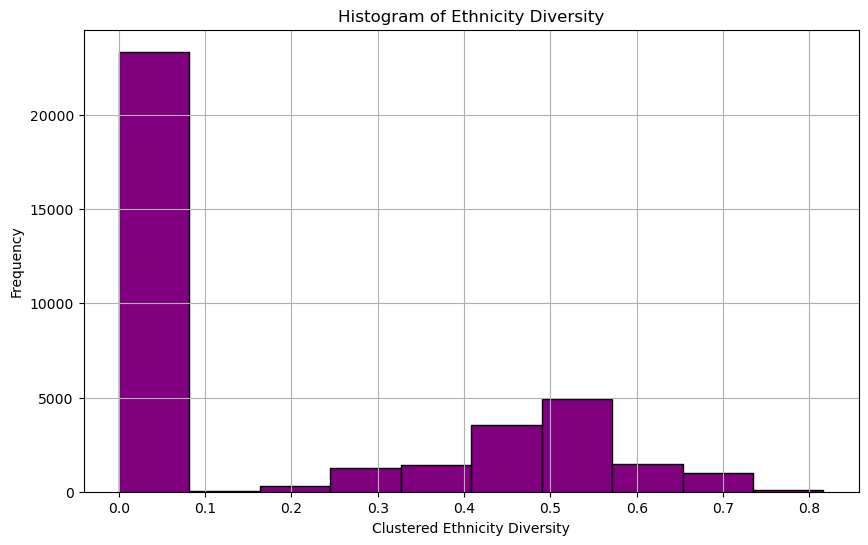

In [ ]:
# Calculating ethnicity diversity and sorting by ethnicity cluster
ethnicity_cluster_diversity_df = calculate_diversity(movie_char_eth_cluster, 'actor_ethnicity_cluster', 'ethnicity_cluster_diversity')
ethnicity_cluster_diversity_df = ethnicity_cluster_diversity_df.drop_duplicates(subset='movie_freebase_id')

# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(ethnicity_cluster_diversity_df['ethnicity_cluster_diversity'], bins=10, color='purple', edgecolor='black')
plt.title('Histogram of Ethnicity Diversity')
plt.xlabel('Clustered Ethnicity Diversity')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

We can see that this approach has several limitations:

- Not all ethnicities have a geographical basis (e.g., Jewish, Irish American, etc.), making it impractical to use k-means clustering with geographical coordinates. As a result, clustering becomes subjective, leading to a disproportionately huge number of individuals being categorized as "Others".

- While on a global scale, a French and an English person are both European, we believe that within a team setting, their cultures and languages can be quite distinct. Therefore, we do not want to lose this nuanced information by grouping them under the same general category.

- The clustering skews the Simpson Diversity Index to 0 due to the grouping of regional diversities into a single general cluster, and the excessive categorization of many ethnicities under "Others".

Finally, although the dataset contains 435 unique ethnicities, the movie with the most actors from different ethnic backgrounds has only 15 distinct ethnicities. This is unlikely to lead to overfitting during regression analysis. Therefore, this sub-section will not be included in the remainder of the study, and we will retain the original ethnic classifications.

# Naive Analysis
In this section, we will begin a naive analysis to understand how the diversity of a movie's cast can potentially influence that movie's performance. Before diving into details, it's important to define what we mean by "naïve analysis" and explain our goal. A naive analysis is a simplified, exploratory approach to studying a phenomenon or a relationship between variables. The aim is to provide an initial understanding of the subject before undertaking more in-depth analyses.

## Ethnic diversity
We will begin by studying ethnic diversity within a movie's cast, in order to understand how it can potentially influence that movie's performance.

In [ ]:
# Load Datasets
ethnicity_diversity_df = pd.read_csv('generated/ethnicity_diversity.csv')

# Display ethnicity_diversity_df dataframe
display(ethnicity_diversity_df)

### Evolution of Ethnic Diversity
First, we will explore the evolution of ethnic diversity within movie castings across different periods of cinema history. The primary objective of this analysis is to trace the change in the ethnic composition of movie castings over time, highlighting significant trends and changes that have taken place.

To do this, we will subdivide the history of cinema into distinct periods, such as 3-year intervals, and examine the ethnic distribution of actors within each period. This approach will allow us to better understand how ethnic representation has evolved in the film industry and identify key moments where significant progress or persistent challenges have been observed.

In [ ]:
# Calculation of average ethnic diversity per 5-year period
ethnicity_diversity_df['year_bin'] = (ethnicity_diversity_df['movie_release_year'] // 3) * 3

# Calculation of the average of ethnic diversity for each 10-year period
average_ethnic_diversity_by_decade = ethnicity_diversity_df.groupby('year_bin')['ethnicity_diversity'].mean().reset_index()

# Creation of the histogram
plt.figure(figsize=(10, 6))
sns.barplot(data=average_ethnic_diversity_by_decade, x='year_bin', y='ethnicity_diversity')
plt.title('Average Ethnic Diversity by Year Range (3 Years)')
plt.xlabel('Range of Years')
plt.ylabel('Average Ethnic Diversity')
plt.xticks(rotation=45)
plt.show()

We see a slight evolution in the ethnic diversity of movie castings over the years. To better understand this evolution, we will detail the results using the cumulative average of ethnicity per year.

In [ ]:
# Calculation of the cumulative sum of annual averages of ethnic diversity
cumulative_average_ethnic_diversity = ethnicity_diversity_df.groupby('movie_release_year')['ethnicity_diversity'].mean().cumsum()

# Creation of the graph
plt.figure(figsize=(10, 6))
cumulative_average_ethnic_diversity.plot(kind='line', marker='o')
plt.title('Evolution of Ethnic Diversity in Films Over Time')
plt.xlabel('Year of Film Release')
plt.ylabel('Cumulative Average of Ethnic Diversity')
plt.grid(True)
plt.show()

There appears to have been a notable positive shift in ethnic diversity in film, suggesting a trend toward more diverse casting choices over the years.

In [ ]:
# Remove rows with NaNs in column "movie_box_office_revenue"
ethnicity_diversity_box_office_df = ethnicity_diversity_df.dropna(subset=['movie_box_office_revenue'])

print(ethnicity_diversity_box_office_df.shape[0])

In [ ]:
# Remove rows with 0 in column "rating_count"
ethnicity_diversity_rating_df = ethnicity_diversity_df.query('rating_count != 0')

print(ethnicity_diversity_rating_df.shape[0])

#### Impact of Ethnic Diversity on Box Office
Let's conduct an analysis that focuses on measuring a movie's performance using its box office receipts as an indicator.

In [ ]:
# Use the 'pearsonr' function to calculate the Pearson correlation
correlation, p_value = pearsonr(ethnicity_diversity_box_office_df['ethnicity_diversity'], ethnicity_diversity_box_office_df['movie_box_office_revenue'])

# Show Pearson correlation and p-value
print("Pearson Correlation : {:.3f}".format(correlation))
print("p-value : {:.3f}".format(p_value))

We calculated a Pearson correlation of approximately 0.217 between the ethnic diversity of a movie's cast and its box office revenue. This positive correlation, significant since the p-value is less than 0.05, suggests that there is an upward trend in box office revenue when the ethnic diversity of the cast is higher.

In order to more precisely evaluate the relationship between the ethnic diversity of the cast and box office revenues, we will perform a regression analysis. This analysis will allow us to determine the extent of the impact of ethnic diversity on box office revenues and to better understand how ethnic diversity influences the financial performance of movies.

In [ ]:
# Preparing data for regression
X = ethnicity_diversity_box_office_df[['ethnicity_diversity']] # Independent variable
y = ethnicity_diversity_box_office_df['movie_box_office_revenue'] # Dependent variable 

# Adding a constant to X
X = sm.add_constant(X)

# Linear regression
model = sm.OLS(y, X).fit()

# Model summary
print(model.summary())

Our results reveal that there is a statistically significant relationship between the ethnic diversity of a film's cast and box office revenue. However, it is essential to note that the relatively low value of the coefficient of determination (R²) indicates that ethnic diversity, taken alone, only partly explains the variation in box office revenue. This suggests the presence of other factors also influencing the financial performance of films.

However, for a better visualization of the relationship between ethnic diversity and box office revenue, we will create a regression graph.

In [ ]:
# Plot the regression graph that shows the relationship between ethnic diversity and box office revenue
plt.figure(figsize=(10, 6))
sns.regplot(
    x='ethnicity_diversity',
    y='movie_box_office_revenue',
    data=ethnicity_diversity_box_office_df,
    line_kws={'color': 'red'},
    ci=95
)
plt.title('Relationship between Ethnic Diversity and Box Office Revenue')
plt.xlabel('Ethnic diversity')
plt.ylabel('Box Office Revenue')
plt.show()

The scatter plot provides a visual representation that complements statistical findings that indicate ethnic diversity is a significant predictor of box office revenue. But despite the positive slope of the regression line, we must be careful not to infer causality from this graph alone. The relationship is purely correlational and further analysis would be needed to draw more definitive conclusions about the impact of ethnic diversity on box office performance.

#### Impact of Ethnic Diversity on Average Rating
Let's conduct an analysis that focuses on measuring a movie's performance using its average rating as an indicator.

In [ ]:
# Use the 'pearsonr' function to calculate the Pearson correlation
correlation, p_value = pearsonr(ethnicity_diversity_rating_df['ethnicity_diversity'], ethnicity_diversity_rating_df['rating_average'])

# Show Pearson correlation and p-value
print("Pearson Correlation : {:.3f}".format(correlation))
print("p-value : {:.3f}".format(p_value))

The Pearson correlation between ethnic diversity and average movie rating is -0.002, with a p-value of 0.812. This suggests a very weak and non-significant correlation between ethnic diversity in films and their average rating. The high p-value indicates that the observed relationship could very well be due to chance, and there is no strong statistical evidence of an association between these two variables.

In order to more precisely evaluate the relationship between the ethnic diversity of the cast and average rating, we will perform a regression analysis. This analysis will allow us to determine the extent of the impact of ethnic diversity on it's average rating and to better understand how ethnic diversity influences the financial performance of movies.

In [ ]:
# Preparing data for regression
X = ethnicity_diversity_rating_df[['ethnicity_diversity']] # Independent variable
y = ethnicity_diversity_rating_df['rating_average'] # Dependent variable 

# Adding a constant to X
X = sm.add_constant(X)

# Linear regression
model = sm.OLS(y, X).fit()

# Model summary
print(model.summary())

The linear regression analysis aligns with our previous results since the table shows that ethnic diversity has a slightly negative association with the average movie rating, as indicated by the coefficient of -0.0101. However, this relationship is not statistically significant at the 5% level in view of the p-value, which suggests that ethnic diversity does not have a significant impact on the average rating of movies according to this model.

For a better visualization of the relationship between ethnic diversity and average rating, we will create a regression graph.

In [ ]:
# Plot the regression graph that shows the relationship between ethnic diversity and average rating
plt.figure(figsize=(10, 6))
sns.regplot(
    x='ethnicity_diversity',
    y='rating_average',
    data=ethnicity_diversity_rating_df,
    line_kws={'color': 'red'},
    ci=95
)
plt.title('Relationship between Ethnic Diversity and Average Rating')
plt.xlabel('Ethnic Diversity')
plt.ylabel('Average Rating')
plt.show()

In conclusion, the scatter plot provides visual confirmation that ethnic diversity, as measured and analyzed in this context, has little to no linear relationship with average movie rating. It suggests that while diversity may be an important cultural and social consideration, its direct relationship with how a film is rated on average is not strong based on this data.

## Gender diversity
Let's continue by studying gender diversity within a movie's cast, in order to understand how it can potentially influence that movie's performance.

In [ ]:
# Load Datasets
gender_diversity_df = pd.read_csv("generated/gender_diversity.csv")

# Display gender_diversity_df dataframe
display(gender_diversity_df)

### Evolution of Gender Diversity
Let's now explore the evolution of gender diversity in film casting across different periods of cinema history. The main objective is, as before, to trace the evolution of the gender distribution in film castings over time.

To do this, as with ethnicity, we will subdivide the history of cinema into 5-year intervals, and examine the gender distribution of actors within each period.

In [ ]:
# Calculation of average gender diversity per 5-year period
gender_diversity_df['year_bin'] = (gender_diversity_df['movie_release_year'] // 5) * 5

# Calculation of the average of gender diversity for each 10-year period
average_gender_diversity_by_decade = gender_diversity_df.groupby('year_bin')['gender_diversity'].mean().reset_index()

# Creation of the histogram
plt.figure(figsize=(10, 6))
sns.barplot(data=average_gender_diversity_by_decade, x='year_bin', y='gender_diversity')
plt.title('Average Gender Diversity by Year Range (5 Years)')
plt.xlabel('Range of Years')
plt.ylabel('Average Gender Diversity')
plt.xticks(rotation=45)
plt.show()

We do not see any particular evolution in gender diversity in film castings over the years. To verify this, we will detail the results using the cumulative average of diversity per year.

In [ ]:
# Calculate the cumulative average of gender diversity per year
cumulative_average_gender_diversity = gender_diversity_df.groupby('movie_release_year')['gender_diversity'].mean().cumsum()

# Create the graph
plt.figure(figsize=(10, 6))
cumulative_average_gender_diversity.plot(kind='line', marker='o')
plt.title('Cumulative Evolution of Gender Diversity in Films Over Time')
plt.xlabel('Year of Film Release')
plt.ylabel('Cumulative Average Gender Diversity')
plt.grid(True)
plt.show()

The line chart shows evidence of a positive dynamic change in gender diversity within the film industry over the years.

### Impact of Gender Diversity
Now, let's undertake an analysis aimed at understanding the influence of gender diversity on the performance of movies.

In [ ]:
# Remove rows with NaNs in column "movie_box_office_revenue"
gender_diversity_box_office_df = gender_diversity_df.dropna(subset=['movie_box_office_revenue'])

print(gender_diversity_box_office_df.shape[0])

In [ ]:
# Remove rows with 0 in column "rating_count"
gender_diversity_rating_df = gender_diversity_df.query('rating_count != 0')

print(gender_diversity_rating_df.shape[0])

#### Impact of Gender Diversity on Box Office
Let's conduct an analysis that focuses on measuring a movie's performance using its box office receipts as an indicator.

In [ ]:
# Use the 'pearsonr' function to calculate the Pearson correlation
correlation, p_value = pearsonr(gender_diversity_box_office_df['gender_diversity'], gender_diversity_box_office_df['movie_box_office_revenue'])

# Show Pearson correlation and p-value
print("Pearson Correlation : {:.3f}".format(correlation))
print("p-value : {:.3f}".format(p_value))

We calculated a correlation of less than -0.000 between the gender diversity within a film's cast and its box office receipts. This correlation indicates an negligible and close to zero relationship between these two variables. In practice, this suggests that there is virtually no linear correlation between gender diversity within a cast and the movie's box office revenue.

To further evaluate the relationship between casting gender diversity and box office revenue, we will perform a regression analysis. This analysis will make it possible to determine the extent of the impact of ethnic diversity on box office revenues and to verify whether, in reality, gender diversity influences the financial performance of movies.

In [ ]:
# Preparing data for regression
X = gender_diversity_box_office_df[['gender_diversity']] # Independent variable
y = gender_diversity_box_office_df['movie_box_office_revenue'] # Dependent variable 

# Adding a constant to X
X = sm.add_constant(X)

# Linear regression
model = sm.OLS(y, X).fit()

# Model summary
print(model.summary())

In summary, the regression analysis indicates that gender_diversity is not a significant predictor of movie_box_office_revenue and that the overall model does not fit the data well. Therefore, it is likely that other variables not included in the model are more predictive of box office revenue, such as ethnic diversity, as discussed previously.

Let's plot a regression graph to visualize the relationship between gender diversity and movie box office revenue

In [ ]:
# Plot the regression graph that shows the relationship between gender diversity and box office revenue
plt.figure(figsize=(10, 6))
sns.regplot(
    x='gender_diversity',
    y='movie_box_office_revenue',
    data=gender_diversity_box_office_df,
    line_kws={'color': 'red'},
    ci=95
)
plt.title('Relationship between Gender Diversity and Box Office Revenue')
plt.xlabel('Gender diversity')
plt.ylabel('Box Office Revenue')
plt.show()

In conclusion, the visual representation on the scatter plot supports the statistical findings from the regression analysis : gender diversity within the cast has no significant linear correlation with the box office revenue of the movies in this dataset.

#### Impact of Gender Diversity on Average Rating
Let's conduct an analysis that focuses on measuring a movie's performance using its average rating as an indicator.

In [ ]:
# Use the 'pearsonr' function to calculate the Pearson correlation
correlation, p_value = pearsonr(gender_diversity_rating_df['gender_diversity'], gender_diversity_rating_df['rating_average'])

# Show Pearson correlation and p-value
print("Pearson Correlation : {:.3f}".format(correlation))
print("p-value : {:.3f}".format(p_value))

The p-value of 0.003 suggests that this correlation is statistically significant, despite being weak, meaning that there is a very small but significant association where movies with higher gender diversity might be associated with slightly lower rating averages.

Let's perform a regression analysis to assess the relationship between gender diversity and average rate, to check this.

In [ ]:
# Preparing data for regression
X = gender_diversity_df[['gender_diversity']] # Independent variable
y = gender_diversity_df['rating_average'] # Dependent variable 

# Adding a constant to X
X = sm.add_constant(X)

# Linear regression
model = sm.OLS(y, X).fit()

# Model summary
print(model.summary())

The linear regression shown in the image indicates a correlation coefficient of -0.0651 for genre diversity, suggesting a weak, even negligible, negative correlation with the average movie rating. However, with a p-value of 0.360, this correlation is not statistically significant, implying that gender diversity, according to this model, does not appear to have a clear impact on the average film rating.

Let's visualize this with a regression graph.

In [ ]:
# Plot the regression graph that shows the relationship between gender diversity and average rating
plt.figure(figsize=(10, 6))
sns.regplot(
    x='gender_diversity',
    y='rating_average',
    data=gender_diversity_df,
    line_kws={'color': 'red'},
    ci=95
)
plt.title('Relationship between Gender Diversity and Average Rating')
plt.xlabel('Gender Diversity')
plt.ylabel('Average Rating')
plt.show()

In conclusion, the visual representation reinforces the statistical analysis that gender diversity, as quantified in this dataset, does not have a significant impact on the average rate of movies. The scatter plot shows a wide distribution of ratings across the levels of gender diversity without a clear pattern or trend, indicating that other factors are likely to be more influential on the average rate than gender diversity.

# Global causal analysis

## Handling data

Firstly, we import the two dataframes that were processed for this task: `gender diversity` and `ethnicity diversity` and filter some NaN values that were not impending previous analyses.  

In [2]:
# csv files paths
gen_data_dir = './generated/'
gender_diversity_file = gen_data_dir + 'gender_diversity.csv'
ethnicity_diversity_file = gen_data_dir + 'ethnicity_diversity.csv'

# Load generated datasets
gender_diverity_df = pd.read_csv(gender_diversity_file)
ethnicity_diversity_df = pd.read_csv(ethnicity_diversity_file)

In [3]:
gender_diverity_df.head()

,movie_freebase_id,movie_name,movie_release_year,movie_languages_count,movie_genres,gender_diversity,actors_count,rating_average,rating_count,movie_box_office_revenue
0,/m/0cc8620,Hemingway & Gellhorn,2012.0,22,"['Romance Film', 'Drama']",0.377164,115,6.000,158,NaN
1,/m/04grkmd,Taking Woodstock,2009.0,22,"['Indie', 'Slice of life story', 'Comedy-drama...",0.409565,87,6.211,405,-0.358824
2,/m/02725hs,Captain Corelli's Mandolin,2001.0,35,"['Film adaptation', 'War film', 'Period piece'...",0.371895,81,5.946,488,1.840898
3,/m/02qr3k8,Terror in the Aisles,1984.0,22,"['Thriller', 'Horror', 'Documentary']",0.491782,78,6.100,37,-0.355676
4,/m/01w8g3,Calendar Girls,2003.0,22,"['Ensemble Film', 'Drama', 'Indie', 'Comedy']",0.492654,66,6.593,350,3.292231


In [4]:
ethnicity_diversity_df.head()

,movie_freebase_id,movie_name,movie_release_year,movie_languages_count,movie_genres,ethnicity_diversity,actors_count,rating_average,rating_count,movie_box_office_revenue
0,/m/031hcx,Harry Potter and the Order of the Phoenix,2007.0,22,"['Mystery', 'Family Film', 'Fantasy Adventure'...",0.744898,28,7.685,18416,7.263377
1,/m/02qr3k8,Terror in the Aisles,1984.0,22,"['Thriller', 'Horror', 'Documentary']",0.850480,27,6.100,37,-0.425137
2,/m/031786,Harry Potter and the Goblet of Fire,2005.0,32,"['Thriller', 'Science Fiction', 'Fantasy Adven...",0.793600,25,7.815,19551,6.908049
3,/m/03l6q0,Scary Movie 3,2003.0,22,"['Parody', 'Horror', 'Absurdism', 'Gross-out f...",0.760417,24,5.977,3815,1.316728
4,/m/011ywj,Gosford Park,2001.0,22,"['Thriller', 'Ensemble Film', 'LGBT', 'Comedy ...",0.548204,23,6.853,997,0.217715


In [5]:
#Filter out movies with no release year
ethnicity_df_filtered = ethnicity_diversity_df.dropna(subset='movie_release_year').copy()
gender_df_filtered = gender_diverity_df.dropna(subset='movie_release_year').copy()
print('ethnicity dataframe : \n\tlen before dropping : {}\n\tlen after dropping : {}'.format(len(ethnicity_diversity_df),len(ethnicity_df_filtered)))
print('gender dataframe : \n\tlen before dropping : {}\n\tlen after dropping : {}'.format(len(gender_diverity_df),len(gender_df_filtered)))

ethnicity dataframe : 
	len before dropping : 12640
	len after dropping : 12513
gender dataframe : 
	len before dropping : 29887
	len after dropping : 29224


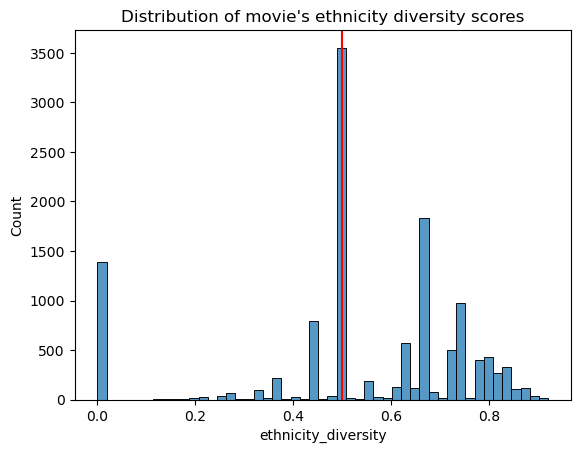

In [6]:
# Plots distribution of simpson ethnicity diversity scores and the median line that differenciates less/more diverse groups
sns.histplot(data = ethnicity_df_filtered,x='ethnicity_diversity')
threshold_ethnicity = ethnicity_df_filtered['ethnicity_diversity'].median()
plt.axvline(x=threshold_ethnicity,c='red')
plt.title('Distribution of movie\'s ethnicity diversity scores')
plt.show()

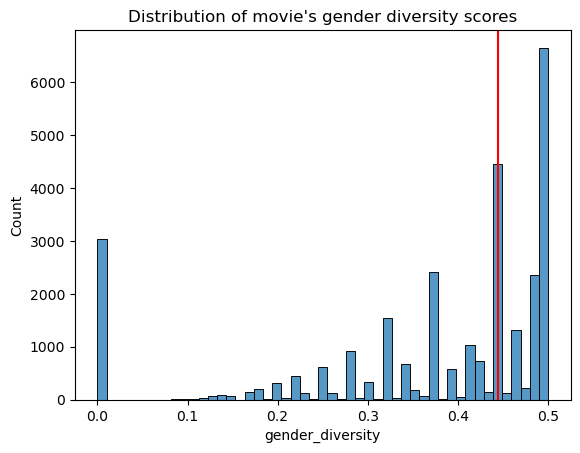

In [7]:
# Plots distribution of simpson gender diversity scores and the median line that differenciates less/more diverse groups
sns.histplot(data = gender_df_filtered,x='gender_diversity')
threshold_gender = gender_df_filtered['gender_diversity'].median()
plt.axvline(x=threshold_gender,c='red')
plt.title('Distribution of movie\'s gender diversity scores')
plt.show()

## Ethnicity to box office 

In this part, we assess the relationship between the performance feature `movie box office revenue` and the diversity feature `ethnic simpson diversity`

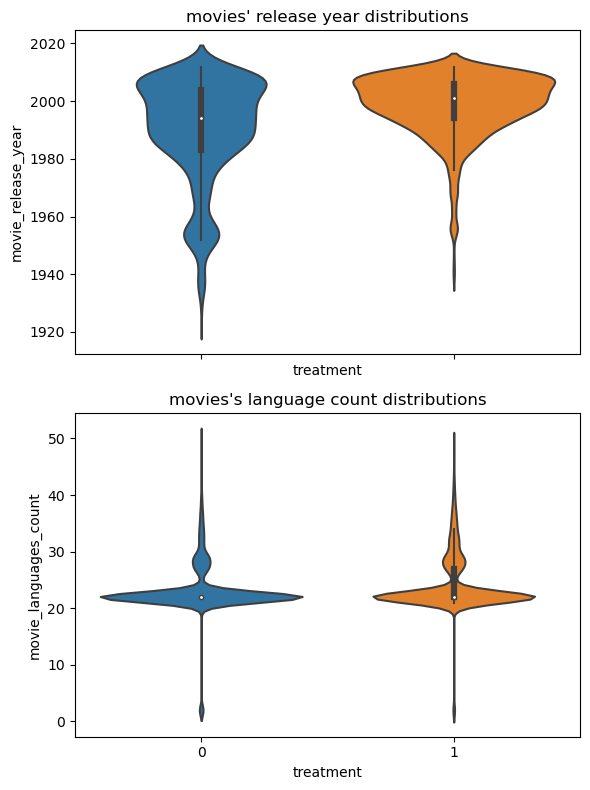

In [8]:
# Define performance and diversity features
perf_var = 'movie_box_office_revenue'
div_var = 'ethnicity_diversity'

# Filter and show the distribution of confounder features
data_unbalanced = filtering(ethnicity_df_filtered,performance_param=perf_var)
data_unbalanced = define_treat_control(data_unbalanced, match_on=div_var)
plot_feature_distrib(df=data_unbalanced)

We see that the distribution of movie release years is very unbalanced between control and treatment groups. To adress this, we perform a propensity score matching and generate a balanced dataframe in regard to those confounders.

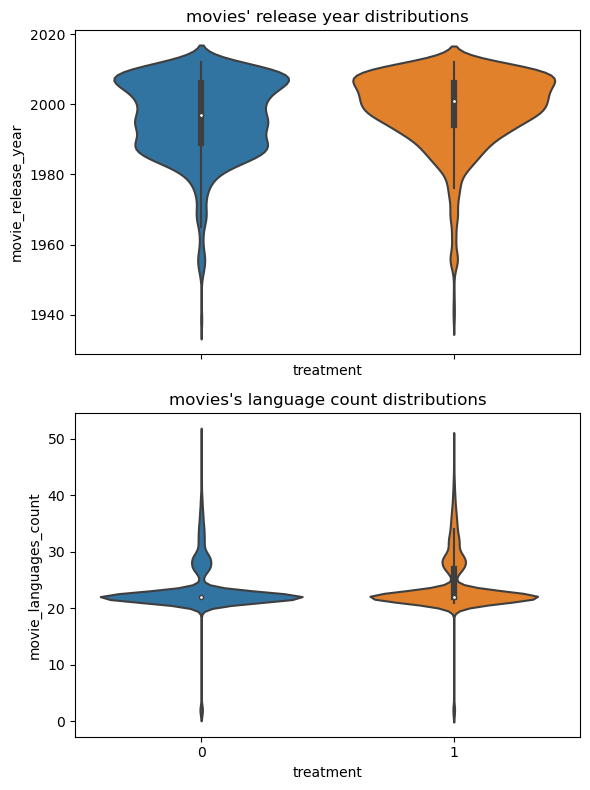

In [9]:
# Show the distribution of confounder features after matching
## box_vs_ethn = balanced_dataset(data=enthnicity_df_filtered,match_on=div_var,perf_var=perf_var,out_df_name='BOR_vs_EthnDiv.csv')
box_vs_ethn = pd.read_csv('./generated/BOR_vs_EthnDiv.csv')
plot_feature_distrib(box_vs_ethn)

Now that the propensity score matching is made, we see on the balanced dataframe that the distributions of release years has a better balance between control and treatment groups, which means those confounder will have a negligible impact on the analysis between our performance and diversity variable.

findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.


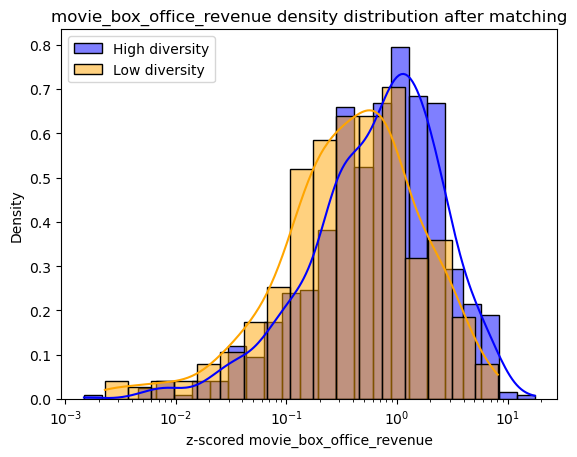

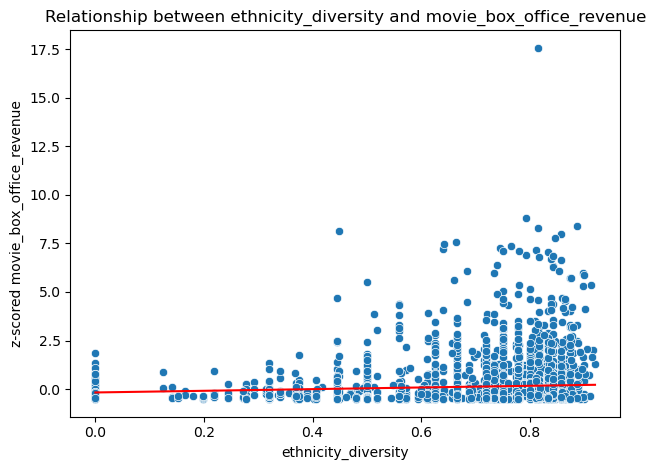

                               OLS Regression Results                               
Dep. Variable:     movie_box_office_revenue   R-squared:                       0.042
Model:                                  OLS   Adj. R-squared:                  0.042
Method:                       Least Squares   F-statistic:                     183.7
Date:                      Thu, 21 Dec 2023   Prob (F-statistic):           5.38e-41
Time:                              17:15:22   Log-Likelihood:                -6036.3
No. Observations:                      4190   AIC:                         1.208e+04
Df Residuals:                          4188   BIC:                         1.209e+04
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------

In [10]:
# Plot balanced density distributions and compute a regression to evaluate correlation
model = compute_results(balanced_df=box_vs_ethn,perf_var=perf_var,diversity_var=div_var)

From the distribution above and statistical tests, we see that the relationship between a movie's box office performance and the fact that it received treatment(having a diverse cast), is a positive ($\beta$>0) and significant (p < 0.05) correlation. It indicates that having a diverse cast in terms of ethnicity brings a better performance in terms of success.

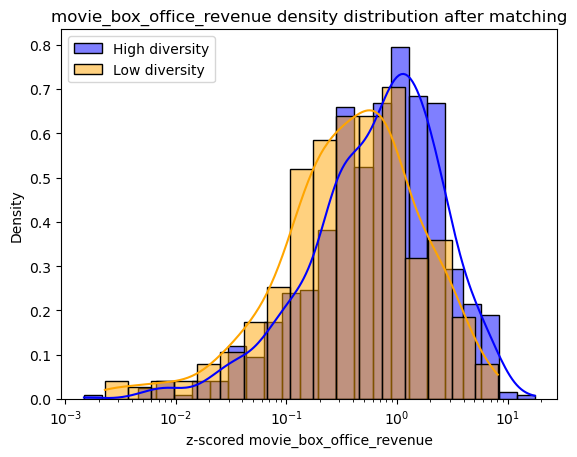

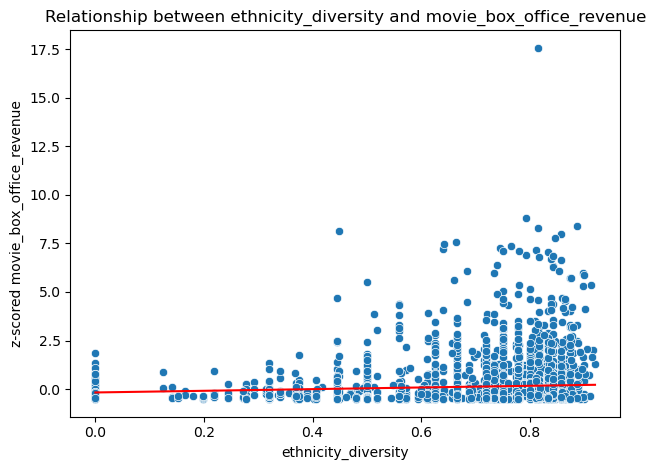

                               OLS Regression Results                               
Dep. Variable:     movie_box_office_revenue   R-squared:                       0.042
Model:                                  OLS   Adj. R-squared:                  0.042
Method:                       Least Squares   F-statistic:                     183.7
Date:                      Thu, 21 Dec 2023   Prob (F-statistic):           5.38e-41
Time:                              17:15:26   Log-Likelihood:                -6036.3
No. Observations:                      4190   AIC:                         1.208e+04
Df Residuals:                          4188   BIC:                         1.209e+04
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------

In [12]:
# Plot balanced density distributions and compute a regression to evaluate correlation
model = compute_results(balanced_df=box_vs_ethn,perf_var=perf_var,diversity_var=div_var)

From the distribution above and statistical tests, we see that the relationship between a movie's box office performance and the fact that it received treatment(having a diverse cast), is a positive ($\beta$>0) and significant (p < 0.05) correlation. It indicates that having a diverse cast in terms of ethnicity brings a better performance in terms of success.

## Gender diversity to box office

In this part, we assess the relationship between the performance feature `movie box office revenue` and the diversity feature `gender simpson diversity`

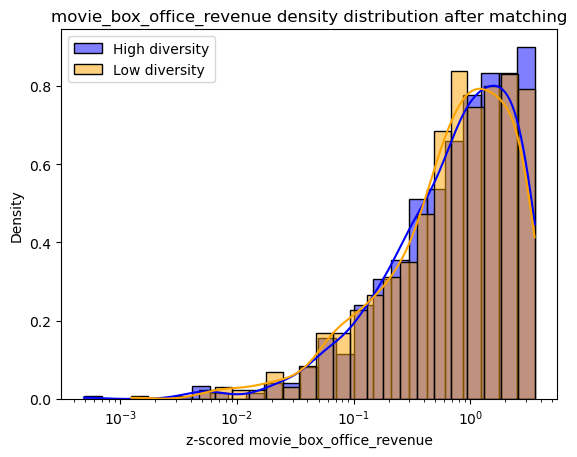

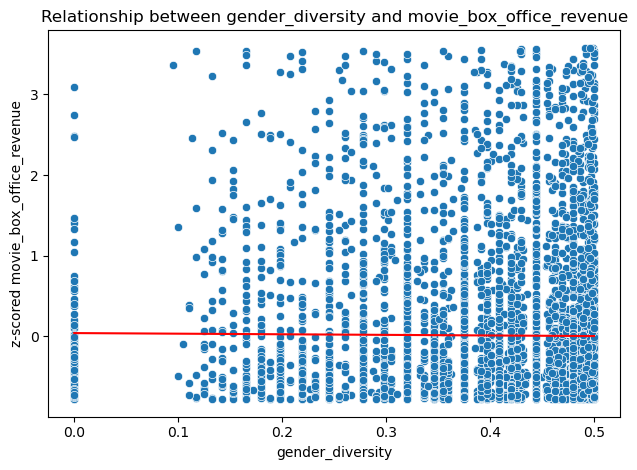

                               OLS Regression Results                               
Dep. Variable:     movie_box_office_revenue   R-squared:                       0.001
Model:                                  OLS   Adj. R-squared:                  0.001
Method:                       Least Squares   F-statistic:                     7.167
Date:                      Thu, 21 Dec 2023   Prob (F-statistic):            0.00745
Time:                              17:15:29   Log-Likelihood:                -7345.0
No. Observations:                      5194   AIC:                         1.469e+04
Df Residuals:                          5192   BIC:                         1.471e+04
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------

In [13]:
# Define performance and diversity features
perf_var = 'movie_box_office_revenue'
div_var = 'gender_diversity'

# Plot balanced density distributions and compute a regression to evaluate correlation
## box_vs_gen = balanced_dataset(data=gender_df_filtered,match_on=div_var,perf_var=perf_var,out_df_name='BOR_vs_GendDiv.csv')
box_vs_gen = pd.read_csv('./generated/BOR_vs_GendDiv.csv')
model = compute_results(balanced_df=box_vs_gen,perf_var=perf_var,diversity_var=div_var)

From the above plot and statistical test, we can notive a few things. The relationship between movie box office revenue and having a diverse cast in terms of gender diversity seems to be negatively ($\beta$<0) correlated (p<0.05). However, we see that the correlation value is way lower than the positive correlation shown between box office revenue and ethnic diversity. Another important point to note is that the explained variance R-squared is way lower, we visually see in the plots that the distributions seem to be very close and the statistical test seems to enhance the idea that the effect is very slow and isn't a reliable explanation of variations in box office revenue.

## Ethnicity diversity to rating average

In this part, we assess the relationship between the performance feature `movie average ratings` and the diversity feature `ethnic simpson diversity`

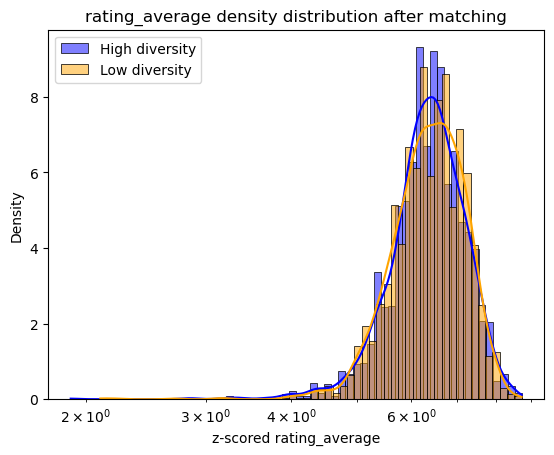

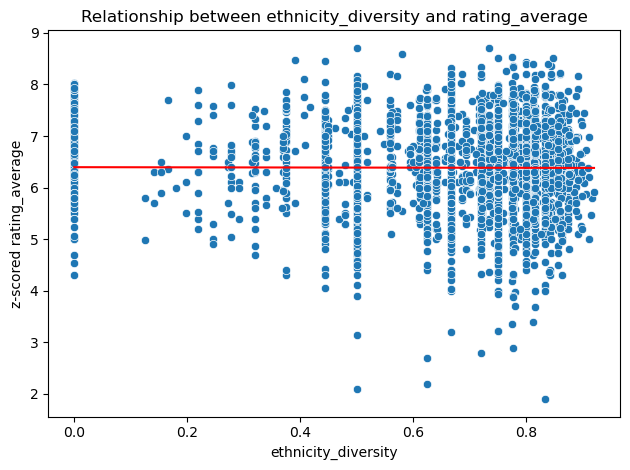

                            OLS Regression Results                            
Dep. Variable:         rating_average   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.4653
Date:                Thu, 21 Dec 2023   Prob (F-statistic):              0.495
Time:                        17:15:31   Log-Likelihood:                -5101.3
No. Observations:                4388   AIC:                         1.021e+04
Df Residuals:                    4386   BIC:                         1.022e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             6.3960      0.01

In [14]:
# Define performance and diversity features
perf_var = 'rating_average'
div_var = 'ethnicity_diversity'

# Plot balanced density distributions and compute a regression to evaluate correlation
## rating_vs_ethn = balanced_dataset(data=ethnicity_df_filtered,match_on=div_var,perf_var=perf_var,out_df_name='AvgR_vs_EthnDiv.csv')
rating_vs_ethn = pd.read_csv('./generated/AvgR_vs_EthnDiv.csv')
compute_results(balanced_df=rating_vs_ethn,perf_var=perf_var,diversity_var=div_var)

The relationship between ethnic diversity and rating averages shows a negative correlation ($\beta$<0) but this time non significant (p>0.05) and the explained variance is near to zero as well. This seems to show that there is no effect between the fact of having a diverse cast in term of ethnicity and the average ratings the movies receive

# Gender diversity to movie average

In this part, we assess the relationship between the performance feature `movie average ratings` and the diversity feature `gender simpson diversity`

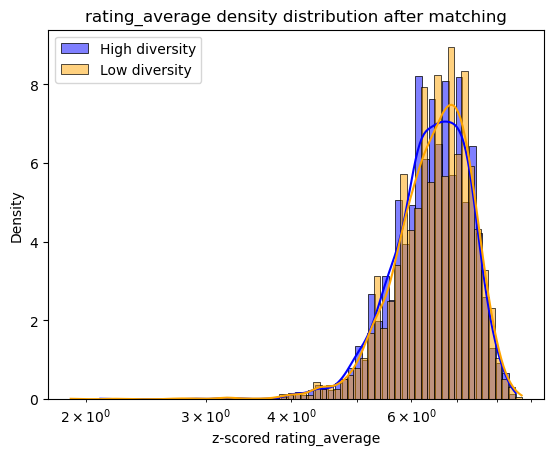

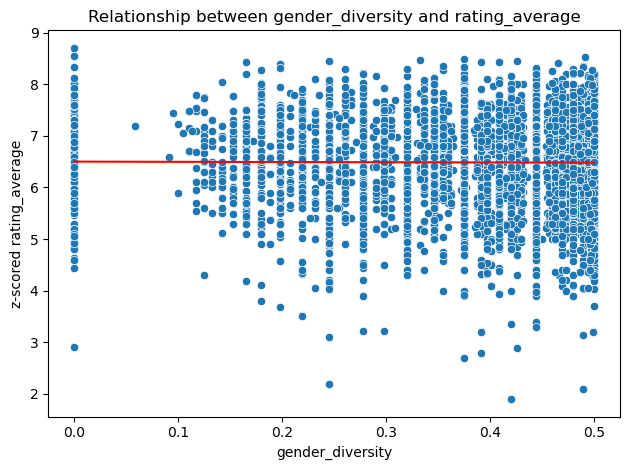

                            OLS Regression Results                            
Dep. Variable:         rating_average   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     4.196
Date:                Thu, 21 Dec 2023   Prob (F-statistic):             0.0406
Time:                        17:15:32   Log-Likelihood:                -7688.6
No. Observations:                6368   AIC:                         1.538e+04
Df Residuals:                    6366   BIC:                         1.539e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             6.5018      0.01

In [15]:
# Define performance and diversity features
perf_var = 'rating_average'
div_var = 'gender_diversity'

# Plot balanced density distributions and compute a regression to evaluate correlation
## rating_vs_gend = balanced_dataset(data=gender_df_filtered,match_on=div_var,perf_var=perf_var,out_df_name='AvgR_vs_GendDiv.csv')
rating_vs_gend = pd.read_csv('./generated/AvgR_vs_GendDiv.csv')
compute_results(balanced_df=rating_vs_gend,perf_var=perf_var,diversity_var=div_var)

The plot and statistical analysis shows similar results than the relationship between gender and movie box office revenue. It has a slight negative significant (p<0.05) correlation that explains a very low part of the variance. One might conclude as well that the importance of gender diversity in this set of movies seem to have low to no impact on average ratings.

## Global analysis, discussion.

From a global viewpoint, the strongest relationship identified was the positive correlation between `movie box office revenue` and `ethnic diversity`. It has the highest explained variance (R=0.040) of all comparisons and a high correlation coefficient (~0.43) considering that the box office revenue variable has been normalized. \
On the other hand, we found negative a correlation between gender diversity and both performance variables but those explain a very negligible part of the variance with an effect lower by a factor 40 when considering revenue and a very small effect as well for ratings. Finally, no significant effect was identified between ethnic diversity and average ratings of movies.

This analysis tends to show that successful movies seem to have a more diverse ethnically diverse casts, regardless of the number of languages the movies were translated to as well as part of the genres and release year. 

# Causal Analysis along the Years

This section aims to determine whether ethnic or gender diversity impacts box office earnings or ratings over different years. However, it's not practical to analyze each year individually. Therefore, we will divide the data into ten year-span segments, each containing approximately the same number of films.

In [ ]:
ethn_div = pd.read_csv('generated/ethnicity_diversity.csv', sep=',')
gen_div = pd.read_csv('generated/gender_diversity.csv', sep=',')
movie_charac = pd.read_csv('generated/movie_characters.csv', sep=',')

### Regression Functions

In [ ]:
def common_movie_gender(str1, str2):  
    '''
    Check if two movies have at least one common genre

    Parameters:
    -str1: A string
    -str2: A string

    Return:
    -common_elements: A boolean
    '''
    # Convert string representation of lists to actual lists
    list1 = [genre.strip() for genre in str1.strip("[]").split(",")]
    list2 = [genre.strip() for genre in str2.strip("[]").split(",")]

    set1 = set(list1)
    set2 = set(list2)
    common_elements = set1.intersection(set2)
    return common_elements

    
def min_max_scaling(df, column_name):
    '''
    Scale the values of a column between 0 and 1

    Parameters:
    -df: A dataframe
    -column_name: A list of string

    Return:
    -df: A dataframe 
    '''
    for col in column_name:
        df[col] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())
    return df

def binarize_diversity(df, column_name):
    '''
    Binarize the diversity column using the median value

    Parameters:
    -df: A dataframe
    -column_name: A string

    Return: 
    -df: A dataframe 
    '''
    median_value = df[column_name].median()
    df['treat'] = np.where(df[column_name] > median_value, 1, 0)
    return df

def add_propensity_score(df,formula_propensity_score,diversity_name,column_name):
    '''
    Add a column with the propensity score to the dataframe

    Parameters:
    -df: A dataframe
    -formula_propensity_score: A string
    -diversity_name: A string
    -column_name: A string
    
    Return: 
    -df: A dataframe 
    '''
    df = binarize_diversity(df,diversity_name)
    df = min_max_scaling(df,column_name)
    mod = smf.logit(formula= formula_propensity_score, data=df)
    res = mod.fit(disp=False)
    df['Propensity_score'] = res.predict()
    return df

def get_similarity(propensity_score1, propensity_score2):
    '''
    Calculate similarity for instances with given propensity scores

    Parameters:
    -propensity_score1: A float
    -propensity_score2: A float
    
    Return: A float
    '''
    return 1-np.abs(propensity_score1-propensity_score2)

def compute_balance_df(df): 
    '''
    Compute a balanced dataframe using the propensity score

    Parameters:
    -df: A dataframe

    Return: 
    -df: A dataframe
    '''
    # Separate the treatment and control groups
    treatment_df = df[df['treat'] == 1]
    control_df = df[df['treat'] == 0]

    # Create an empty graph
    G = nx.Graph()

    # Loop through all the pairs of instances
    for control_id, control_row in control_df.iterrows():
        for treatment_id, treatment_row in treatment_df.iterrows():
            # Check if the two instances have the same number of languages and at least one common genre
            if (control_row['movie_languages_count'] == treatment_row['movie_languages_count']) \
                and common_movie_gender(control_row['movie_genres'], treatment_row['movie_genres']):
                # Calculate the similarity 
                similarity = get_similarity(control_row['Propensity_score'],
                                            treatment_row['Propensity_score'])

                # Add an edge between the two instances weighted by the similarity between them
                G.add_weighted_edges_from([(control_id, treatment_id, similarity)])

    # Generate and return the maximum weight matching on the generated graph
    matching = nx.max_weight_matching(G)

    matched = [i[0] for i in list(matching)] + [i[1] for i in list(matching)]
    balanced_df = df.loc[matched]
    return balanced_df

def regression(df,formula,formula_propensity_score,diversity_name,column_name):
    '''
    Perform an ols regression on a dataframe according to the formula

    Parameters:
    -df: A dataframe
    -formula: A string
    -formula_propensity_score: A string
    -diversity_name: A string
    -column_name: A lsit of string

    Return: 
    -balanced_df: A dataframe 
    -mod: A model
    '''
    df = add_propensity_score(df, formula_propensity_score, diversity_name, column_name)
    balanced_df = compute_balance_df(df)
    mod = smf.ols(formula=formula, data=balanced_df)
    return balanced_df,mod


def compute_all_regressions(period_df,formula,formula_propensity_score,diversity_name,columns):
    '''
    Perform the regression for each period and store the results in a list

    Parameters:
    -period_df: A dataframe
    -formula: A string
    -formula_propensity_score: A string
    -diversity_name: A string
    -columns: A lsit of string


    Return: 
    -balanced_dfs: A list of tuples containing the balanced dataframe
    -mods: A list of tuples containing the model
    '''
    # Create an empty list to store the results
    results = []

    # Iterate over periods
    for period_num in range(1, 11):
        period_key = f'df_period{period_num}'
        
        # Perform regression for each period
        balanced_df, mod = regression(
            period_df[period_key],
            formula=formula,
            formula_propensity_score=formula_propensity_score,
            diversity_name=diversity_name,
            column_name=columns
        )
        
        # Store the results in a tuple and append to the list
        result = (balanced_df, mod)
        results.append(result)

    # Extract the results for each period
    balanced_dfs, mods = zip(*results)
    return balanced_dfs,mods

### Visualization Functions

In [ ]:
def plot_regression_line(balanced_dfs,mods,
                         cutoff,param_div,param_perf,
                         xlabel='Ethnicity Diversity',ylabel='Box Office Revenue'):
    '''
    Plot the regression line and the datapoints for each period
    '''
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 8))
    axes = axes.flatten()
    for i in range(10):
        df = balanced_dfs[i]
        mod = mods[i]
        #Extract the intercept and the slope
        intercept_coef = mod.fit().params['Intercept']
        ethnicity_coef = mod.fit().params[param_div]
        #Plot the regression line
        x_values = np.linspace(min(df[param_div]), max(df[param_div]), 100)
        y_values = intercept_coef + ethnicity_coef * x_values
        axes[i].plot(x_values, y_values, color='red', label='Regression Line')
        #Plot the datapoints
        axes[i].scatter(df[param_div], df[param_perf], s=5, label='Data Points')
        axes[i].set_xlabel(f'{xlabel}: pval= {mod.fit().pvalues[param_div].round(3)}, intercept pval= {mod.fit().pvalues["Intercept"].round(3)}, \n intercept={mod.fit().params["Intercept"].round(3)} ,slope= {mod.fit().params[param_div].round(3)}')
        axes[i].set_ylabel(ylabel)
        axes[i].legend()
        if i < len(cutoff)-1:
            axes[i].set_title(f'{int(cutoff[i])} - {int(cutoff[i+1])}')
        if i == len(cutoff)-1:
            axes[i].set_title(f'{int(cutoff[i])} - {int(df["movie_release_year"].max())}')
    plt.tight_layout()
    plt.show()


def plot_comparison(balanced_dfs,cutoff,param_perf):
    '''
    Plot the distribution of the performance parameter for each group for each period
    '''
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 8))
    axes = axes.flatten()
    for i in range(10):
        df = balanced_dfs[i]
        #Recollect the movie box office revenue for each movie
        movie_charac['movie_name'].drop_duplicates(keep='first',inplace=True)
        movie_charac_reduced = movie_charac[['movie_freebase_id','movie_box_office_revenue']]
        movie_charac_reduced.rename(columns={'movie_box_office_revenue':'Box_office'},inplace=True)
        merge = pd.merge(balanced_dfs[i],movie_charac_reduced,how='left',on='movie_freebase_id')
        #Split the dataframe according to the group
        treatment_df = merge[merge['treat'] == 1]
        control_df = merge[merge['treat'] == 0]
        ax = axes[i]
        #Plot the distribution of the performance parameter for each group
        if param_perf == 'Box_office':
            sns.histplot(treatment_df[param_perf], label='Treat', kde=True, stat='density', color='blue', log_scale=True, ax=ax)
            sns.histplot(control_df[param_perf], label='Control', kde=True, stat='density', color='orange', log_scale=True, ax=ax)
        elif param_perf == 'rating_average':
            sns.histplot(treatment_df[param_perf],label='Treat', kde=True, stat='density', color='blue', ax=ax)
            sns.histplot(control_df[param_perf],label='Control', kde=True, stat='density', color='orange', ax=ax)
        if param_perf == 'Box_office':
            ax.set_xlabel('Movie Box Office Revenue')
        elif param_perf == 'rating_average':
            ax.set_xlabel('Movie Rating Average')
        ax.set_ylabel('Density')
        ax.legend()
        if i < len(cutoff)-1:
            ax.set_title(f'{int(cutoff[i])} - {int(cutoff[i+1])}')
        if i == len(cutoff)-1:
            ax.set_title(f'{int(cutoff[i])} - {int(df["movie_release_year"].max())}')
    plt.tight_layout()
    plt.show()

### Ethnicity vs Box office

In this section we will try to figure out if there is a correlation between the diversity of a cast (in terms of ethnicity) and the box office revenue of a movie. The values in the columns `ethnicity_diversity` is based on the number of different ethnicity in the cast of movie. It is computed with the simpson diversity.  
Then for each part of the dataframe we perfomed a causal analysis on the Movie Box Office Revenue by performing a propensity score matching on the `movie_languages_count` and on the `rating_average`. Finally we performed an Ordinary Least Squares (OLS) regression analysis on the balanced dataset. 

In [ ]:
#Filter the dataframe according to the performance parameter
ethn_div_filter = filtering(ethn_div,'box_office')

#Split the dataframe in number_parts according to the year of release
period_df ,cutoff = year_release_split(ethn_div_filter, number_parts=10)

#Perform the regression for each period 
balanced_dfs, mods = compute_all_regressions(period_df=period_df,
                        formula = 'movie_box_office_revenue ~ ethnicity_diversity',
                        formula_propensity_score = 'ethnicity_diversity ~ movie_languages_count + rating_average',
                        diversity_name = 'ethnicity_diversity',
                        columns = ['movie_languages_count','rating_average'])

print('Size of the Dataframe before Filtering :',ethn_div.shape[0])
print('Size of the Dataframe after Filtering :',ethn_div_filter.shape[0])

In [ ]:
plot_regression_line(balanced_dfs,mods,cutoff,'ethnicity_diversity','movie_box_office_revenue')

The movies are splited in 10 groups according to their year of release with approximately the same number of movies in each.   
We can notice a statistically significative positive correlation (pvalue(Ethnicity Diversity) < 0.05) between the Ethnicity Diversity and the Box Office Revenue along the years except for the year range (1925-1973).   
One reason may explain this difference:
- The dataframe is missing many actors per movie for the ones released before the 70's 

Perhaps having a diviersified cast was not correlated with a better Box Office Revenue before the 70's however, from the 70's to nowadays it does has an impact. More the casting is Diversified in terms of ethnicity more the box office revenue will be high.  

In [ ]:
plot_comparison(balanced_dfs,cutoff,'Box_office')

This plot shows the distribution of the 2 groups (Control (Low Diversity) and Treatment (High Diversity)) of the Box Office Revenue. As stated before the movies are splited in 10 as well. It allows to figure out if there is a difference along the time between the control and treatement group. Overall, the movie box office for the treated group is higher than the one of the control group except for the year range (1925-1973). Therefore, according to both plots above, we can conclude that the treatment (High Diversity) has an impact on the box office revenue of a movie after the 70's.

 

### Gender vs Box office

In this section we will try to figure out if there is a correlation between the diversity of a cast (in terms of gender) and the box office revenue of a movie. The values in the columns `gender_diversity` is based on the number of different ethnicity in the cast of movie. It is computed with the simpson diversity.  
Then for each part we perfomed a causal analysis on the Movie Box Office Revenue by performing a propensity score matching on the `movie_languages_count` and on the `rating_average`. Finally, we performed an Ordinary Least Squares (OLS) regression analysis on the balanced dataset. 

In [ ]:
#Filter the dataframe according to the performance parameter
gen_div_filter = filtering(gen_div,'box_office')

#Split the dataframe in number_parts according to the year of release
period_df_gb ,cutoff_gb = year_release_split(gen_div_filter, number_parts=10)

#Perform the regression for each period
balanced_dfs_gb, mods_gb = compute_all_regressions(period_df=period_df_gb,
                        formula = 'movie_box_office_revenue ~ gender_diversity',
                        formula_propensity_score = 'gender_diversity ~ movie_languages_count + rating_average',
                        diversity_name = 'gender_diversity',
                        columns = ['movie_languages_count','rating_average'])

print('Size of the Dataframe before filtering :',gen_div.shape[0])
print('Size of the Dataframe after filtering :',gen_div_filter.shape[0])


In [ ]:
plot_regression_line(balanced_dfs_gb,mods_gb,cutoff_gb,'gender_diversity','movie_box_office_revenue', 'Gender Diversity')

On these plots above the regression line (in red) is very flat, furthermore the pvalue of the Gender Diversity is alaways above 0.05 which means that we cannot reject the null hypothesis (there is no difference between the treated and the control group for the box office revenue). 

In [ ]:
plot_comparison(balanced_dfs_gb,cutoff_gb,'Box_office')

This plot shows the distribution of the 2 groups (Control (Low Diversity) and Treatment (High Diversity)) of the Box Office Revenue. According to the plot there is no difference between the 2 groups because both distributions overlap.  
After examining both plots, it can be inferred that there is no correlation bewtween the diversity in a cast (in terms of gender) and the movie box office revenue of a movie.

### Ethnicity vs Ratings

In this section we will try to figure out if there is a correlation between the diversity of a cast (in terms of ethnicity) and the rating of a movie. The values in the columns `ethnicity_diversity` is based on the number of different ethnicity in the cast of movie. It is computed with the simpson diversity.  
Then, for each part we perfomed a causal analysis on the Rating by performing a propensity score matching on the `movie_languages_count` and on the `movie_box_office_revenue`. Finally, we performed an Ordinary Least Squares (OLS) regression analysis on the balanced dataset. 

In [ ]:
#Filter the dataframe according to the performance parameter
ethn_div_filter_r = filtering(ethn_div,'rating')

#Split the dataframe in number_parts according to the year of release
period_df_er ,cutoff_er = year_release_split(ethn_div_filter_r, number_parts=10)

#Perform the regression for each period
balanced_dfs_er, mods_er = compute_all_regressions(period_df=period_df_er,
                        formula = 'rating_average ~ ethnicity_diversity',
                        formula_propensity_score = 'ethnicity_diversity ~ movie_languages_count + movie_box_office_revenue',
                        diversity_name = 'ethnicity_diversity',
                        columns = ['movie_languages_count','rating_average'])

print('Size of the Dataframe before Filtering :',ethn_div.shape[0])
print('Size of the Dataframe after Filtering :',ethn_div_filter_r.shape[0])


In [ ]:
plot_regression_line(balanced_dfs_er,mods_er, cutoff_er,'ethnicity_diversity', 'rating_average', 'Ethnicity Diversity', 'Rating Average')


On these plots above the regression line (in red) is very flat or slightly goes down, furthermore on most of them, the pvalue of the Ethnicity Diversity is alaways above 0.05 which means that we cannot reject the null hypothesis (there is no difference between the treated and the control group for the box office revenue). For the movies released between 2005 and 2008 the pvalue is below 0.05 and the slope is negative which can be translated by a statistically significant negative correlation between the ethnicity diversity and the rating of a movie.

In [ ]:
plot_comparison(balanced_dfs_er,cutoff_er,'rating_average')

This plot shows the distribution of the 2 groups (Control (Low Diversity) and Treatment (High Diversity)) of the Rating of a movie. According to the plot there is almost no difference between the 2 distributions. They overlap most of time. Sometimes the treatment is even more on the left which means that the the movies with the lowest diversity get a better rating.  
It is hard to conclude based on the analysis of both plots but we can affirm at least there is no positive correlation between the diversity in terms of ethnictiy and the rating of a movie. As in most of the year range there is no correlation between the diversity and the rating it might be the case on the entire period. To obtain more precision please check out the causal analysis on the entire period.

### Gender vs Ratings

In this section we will try to figure out if there is a correlation between the diversity of a cast (in terms of gender) and the rating of a movie. The values in the columns `gender_diversity` is based on the number of different ethnicity in the cast of movie. It is computed with the simpson diversity.  
Then, for each part we perfomed a causal analysis on the Rating by performing a propensity score matching on the `movie_languages_count` and on the `movie_box_office_revenue`. Finally, we performed an Ordinary Least Squares (OLS) regression analysis on the balanced dataset. 

In [ ]:
#Filter the dataframe according to the performance parameter
gen_div_filter_r = filtering(gen_div,'rating')

#Split the dataframe in number_parts according to the year of release
period_df_gr ,cutoff_gr = year_release_split(gen_div_filter_r, number_parts=10)

#Perform the regression for each period
balanced_dfs_gr, mods_gr = compute_all_regressions(period_df=period_df_gr,
                        formula = 'rating_average ~ gender_diversity',
                        formula_propensity_score = 'gender_diversity ~ movie_languages_count + movie_box_office_revenue',
                        diversity_name = 'gender_diversity',
                        columns = ['movie_languages_count','rating_average'])

print('Size of the Dataframe before filtering :',gen_div.shape[0])
print('Size of the Dataframe after filtering :',gen_div_filter_r.shape[0])

In [ ]:
plot_regression_line(balanced_dfs_gr,mods_gr, cutoff_gr,'gender_diversity', 'rating_average', 'Gender Diversity', 'Rating Average')


On these plots above the regression line (in red) is very flat or slightly goes down, furthermore the pvalue of the Ethnicity Diversity is alaways above 0.05 which means that we cannot reject the null hypothesis (there is no difference between the treated (movies with a high diversity) and the control (movies with a low diversity) group for the box office revenue). 

In [ ]:
plot_comparison(balanced_dfs_gr,cutoff_gr,'rating_average')

This plot shows the distribution of the 2 groups (Control (Low Diversity) and Treatment (High Diversity)) of the Rating of a movie. According to the plot there is  no difference because both distributions overlap most of time.
Based on the analysis of both plots but we can affirm at least there is no positive correlation between the diversity in terms of ethnictiy and the rating of a movie. 